# Model Training: Household Consumption Nowcast

## Objectives of Notebook

This notebook aims to:

* Perform train/validation split on dataset.
* Perfrom baseline model evaluation.
* Perform Hyperparameter tuning & optimisation.
* Save trained model to pickle file.

## Import Libraries

In [1]:
%autosave 60
%load_ext autoreload
%autoreload 2

Autosaving every 60 seconds


In [2]:
import warnings
import logging
from darts import TimeSeries
from darts.models import AutoARIMA, Prophet, KalmanForecaster, XGBModel, RNNModel, RegressionModel
from sklearn.linear_model import LinearRegression, BayesianRidge, HuberRegressor
from darts.dataprocessing.transformers import Scaler
from matplotlib import pyplot as plt

# Libraries Settings
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

## Import Customised Functions from Source Code

In [3]:
# Import Functions for Plotting
from src.plot import  plot_train_val, plot_pred_ml, plot_ml_backtest

# Import Functions for Utilities
from src.utils import split_len, month_diff_ts

# Import Functions for Model Training
from src.train import eval_model_ml, model_pkl

## Import Preprocessed Data

* Data that have been preprocessed on previous notebook.

In [4]:
# Load previous DataFrame from previous notebook
%store -r debit
%store -r credit
%store -r ue_bank
%store -r ue_nonbank
%store -r qris
%store -r digital_banking
%store -r household_consumption
%store -r electronic_transaction_nom
%store -r google_trends


### Convert DataFrame to TimeSeries format

In [5]:
# Convert household_consumption DataFrames into TimeSeries
household_consumption = TimeSeries.from_dataframe(household_consumption, value_cols='household_consumption', fill_missing_dates=True, freq=None)

# Convert electronic_transaction_nom DataFrames into TimeSeries
electronic_transaction_nom = TimeSeries.from_dataframe(electronic_transaction_nom, value_cols='electronic_transac_nom', fill_missing_dates=True, freq=None)

# Convert google_trends DataFrames into TimeSeries
google_trends = TimeSeries.from_dataframe(google_trends, value_cols='google_trends', fill_missing_dates=True, freq=None)


## Train/validation Split

### Split 'household_consumption' into Train & Validation Set (80:20)

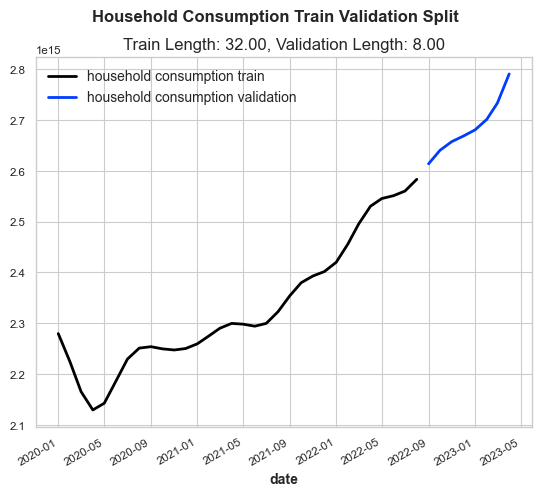

In [6]:
# Get the len for each train and validation set using split_len function
train_household_consumption_len = split_len(household_consumption, 0.8)
val_household_consumption_len = split_len(household_consumption, 0.2)

# Split household_consumption into train and validation set with 80:20 ratio
train_household_consumption, val_household_consumption = household_consumption[:train_household_consumption_len], household_consumption[train_household_consumption_len:]

# Plot household_consumption train validation Split
plot_train_val(train=train_household_consumption, 
                    train_label='household consumption train', 
                    val=val_household_consumption, 
                    val_label='household consumption validation', 
                    suptitle='Household Consumption Train Validation Split')

### Instantiate covariates

Text(0.5, 1.0, 'Combined Covariates')

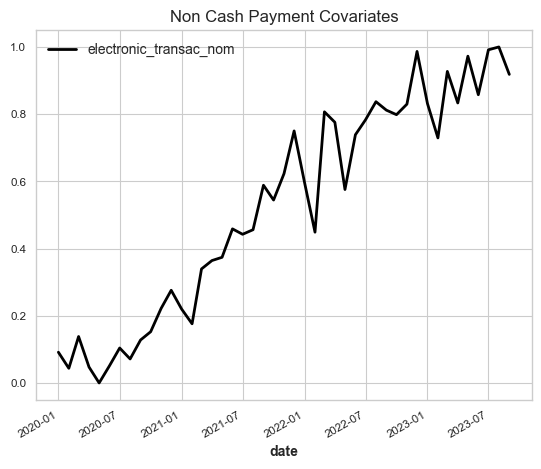

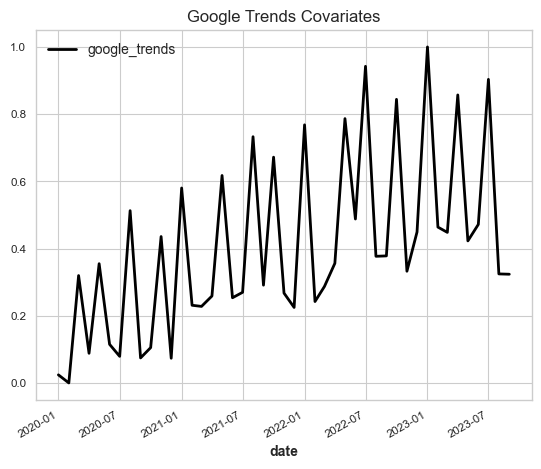

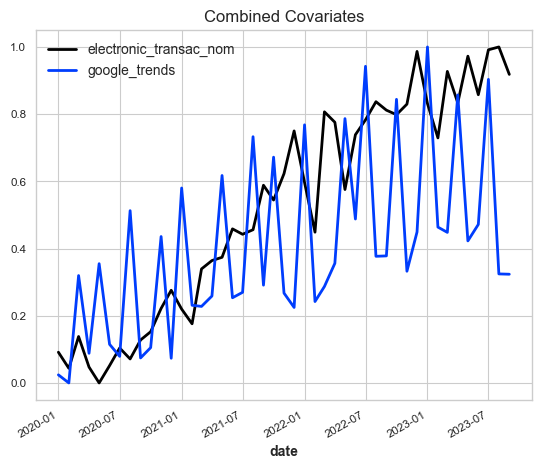

In [7]:
# Stack electronic_transaction_nom and googleTrend to create combined covariate
combined = electronic_transaction_nom.stack(google_trends)

#  Scale electronic_transaction_nom, google_trends, & combinated covariate for plotting
scaler = Scaler()
electronic_transaction_nom_scaled = scaler.fit_transform(electronic_transaction_nom)
google_trends_scaled = scaler.fit_transform(google_trends)
combined_scaled = electronic_transaction_nom_scaled.stack(google_trends_scaled)

# Plot the covariates
plt.figure()
electronic_transaction_nom_scaled.plot()
plt.title("Non Cash Payment Covariates")

plt.figure()
google_trends_scaled.plot()
plt.title("Google Trends Covariates")

plt.figure()
combined_scaled.plot()
plt.title("Combined Covariates")

## Baseline Model Evaluation

### Statistical Models

In [8]:
# Use eval_model_ml function to evaluate the performance of classical models with future covariates
eval_model_ml(KalmanForecaster(), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(AutoARIMA(), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(Prophet(), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)

KalmanForecaster() - MAPE: 5.87%, RMSE: 157944M, MAE: 148539M, Score: 9.4
AutoARIMA() - MAPE: 2.55%, RMSE: 93409M, MAE: 66481M, Score: 4.9
Prophet() - MAPE: 3.68%, RMSE: 113199M, MAE: 94678M, Score: 6.4


### Regression Models

In [9]:
# Use eval_model_ml function to evaluate the performance of regression models with future covariates
eval_model_ml(RegressionModel(model=LinearRegression(), lags=val_household_consumption_len, lags_future_covariates=(16,8), output_chunk_length=val_household_consumption_len,), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(RegressionModel(model=BayesianRidge(), lags=val_household_consumption_len, lags_future_covariates=(16,8), output_chunk_length=val_household_consumption_len,), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(RegressionModel(model=HuberRegressor(), lags=val_household_consumption_len, lags_future_covariates=(16,8), output_chunk_length=val_household_consumption_len,), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(XGBModel(lags=val_household_consumption_len, lags_future_covariates=(16,8), output_chunk_length=val_household_consumption_len,), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)

LinearRegression() - MAPE: 1.32%, RMSE: 38415M, MAE: 34777M, Score: 2.2
MultiOutputRegressor(estimator=BayesianRidge()) - MAPE: 1.28%, RMSE: 37918M, MAE: 33718M, Score: 2.2
MultiOutputRegressor(estimator=HuberRegressor()) - MAPE: 1.27%, RMSE: 38792M, MAE: 33385M, Score: 2.2
MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                 

### Recurrent Neural Network (RNN) Models

In [10]:
# Use eval_model_ml function to evaluate the performance of classical models with future covariates
eval_model_ml(RNNModel(model="RNN", input_chunk_length=train_household_consumption_len-2, training_length=train_household_consumption_len-2, random_state=42), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(RNNModel(model="GRU", input_chunk_length=train_household_consumption_len-2, training_length=train_household_consumption_len-2, random_state=42), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)
eval_model_ml(RNNModel(model="LSTM", input_chunk_length=train_household_consumption_len-2, training_length=train_household_consumption_len-2, random_state=42), val_household_consumption_len, train_household_consumption, val_household_consumption, combined)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

RNNModel(training_length=30, input_chunk_length=30, random_state=42) - MAPE: 4.81%, RMSE: 131766M, MAE: 123248M, Score: 7.8


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

RNNModel(model=GRU, training_length=30, input_chunk_length=30, random_state=42) - MAPE: 5.25%, RMSE: 141324M, MAE: 134048M, Score: 8.5


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

RNNModel(model=LSTM, training_length=30, input_chunk_length=30, random_state=42) - MAPE: 1.02%, RMSE: 43388M, MAE: 27315M, Score: 9.5


## Hyperparameter Tuning & Model Training

In [11]:
# Get the difference in len between household_consumption and all covariates
google_trends_diff_len = month_diff_ts(household_consumption, google_trends)
electronic_transaction_nom_diff_len = month_diff_ts(household_consumption, electronic_transaction_nom)
combined_diff_len = month_diff_ts(household_consumption, combined)

## Prophet

##### Evaluate Prophet with Google Trends Covariate

In [12]:
# Initialize Prophet model for training with Google Trends data as future covariates
prophet_google_trends = Prophet(
                            add_seasonalities={
                            'name':"monthly",
                            'seasonal_periods':30,
                            'fourier_order':1,
                            }, country_holidays='ID')

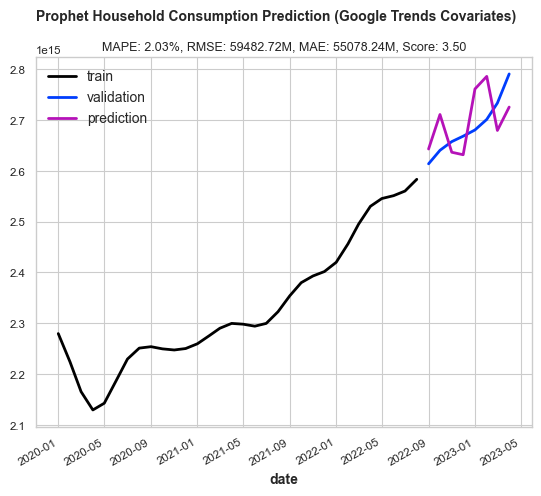

In [13]:
# Fit Prophet model with train_household_consumption and google_trends using plot_pred_ml function
plot_pred_ml(model = prophet_google_trends, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = google_trends, 
                 suptitle = 'Prophet Household Consumption Prediction (Google Trends Covariates)')

##### Historical Forecast (backtest) Prophet Model with Google Trends Covariates on Full Dataset

  0%|          | 0/9 [00:00<?, ?it/s]

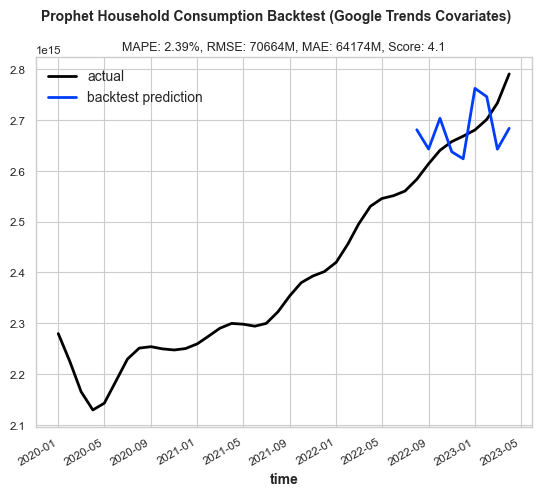

In [14]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=prophet_google_trends, 
                train=household_consumption,
                cov=google_trends,
                suptitle='Prophet Household Consumption Backtest (Google Trends Covariates)',
                start_val=0.8)

##### Save Prophet Model Used to Nowcast on Full Dataset with Google Trends Covariate

In [15]:
model_pkl(model=prophet_google_trends, pickle_name='household_consumption_prophet_google_trends')

household_consumption_prophet_google_trends saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate Prophet with Electronic Transaction Nominal Covariate

In [16]:
# Initialize Prophet model for training with Electronic Payment Transaction data as future covariates
prophet_electronic_transaction_nom = Prophet(
                                    add_seasonalities={
                                    'name':"monthly",
                                    'seasonal_periods':30,
                                    'fourier_order':1,
                                    }, country_holidays='ID')

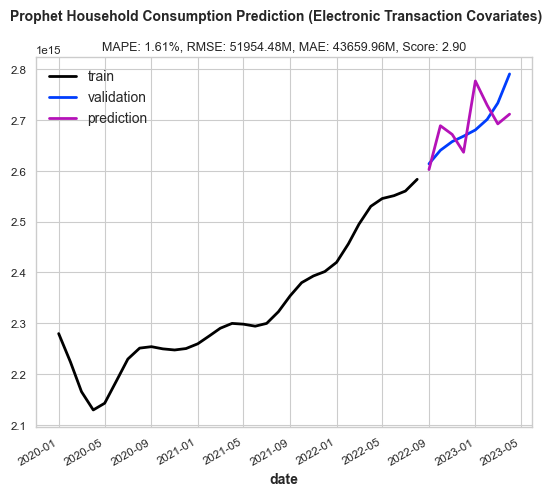

In [17]:
# Fit the model with train_household_consumption and electronic_transaction_nom
plot_pred_ml(model = prophet_electronic_transaction_nom, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = electronic_transaction_nom, 
                 suptitle='Prophet Household Consumption Prediction (Electronic Transaction Covariates)')

##### Historical Forecast (backtest) Prophet Model with Electronic Transaction Nominal Covariates on Full Dataset

  0%|          | 0/9 [00:00<?, ?it/s]

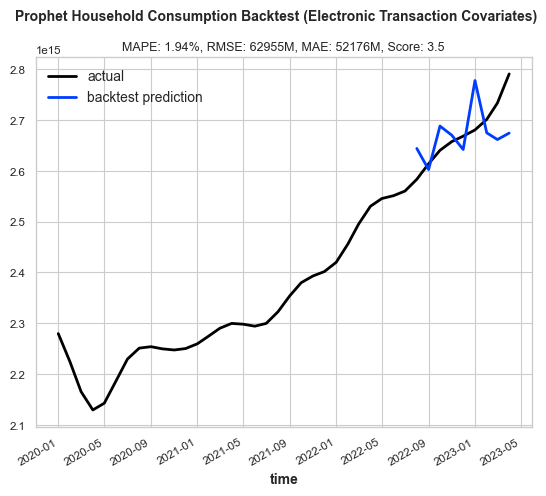

In [18]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=prophet_electronic_transaction_nom, 
                 train=household_consumption,
                 cov=electronic_transaction_nom,
                 suptitle='Prophet Household Consumption Backtest (Electronic Transaction Covariates)',
                 start_val=0.8)

##### Save Prophet Model used to Nowcast on Full Dataset with Electronic Transaction Nominal Covariates

In [19]:
model_pkl(prophet_electronic_transaction_nom, 'household_consumption_prophet_electronic_transaction_nom')

household_consumption_prophet_electronic_transaction_nom saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate Prophet with Combined Covariate

In [20]:
# Initialize Prophet model for training with combined covariate
prophet_combined = Prophet(
                        add_seasonalities={
                        'name':"monthly",
                        'seasonal_periods':30,
                        'fourier_order':1,
                        }, country_holidays='ID')

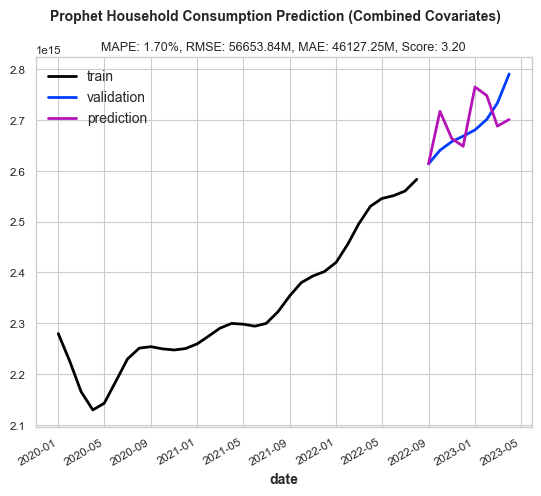

In [21]:
# Fit the Prophet model with train_household_consumption and combined
plot_pred_ml(model = prophet_combined, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = combined, 
                 suptitle='Prophet Household Consumption Prediction (Combined Covariates)')

##### Historical Forecast (backtest) Prophet Model with Combined Covariates on full Dataset

  0%|          | 0/9 [00:00<?, ?it/s]

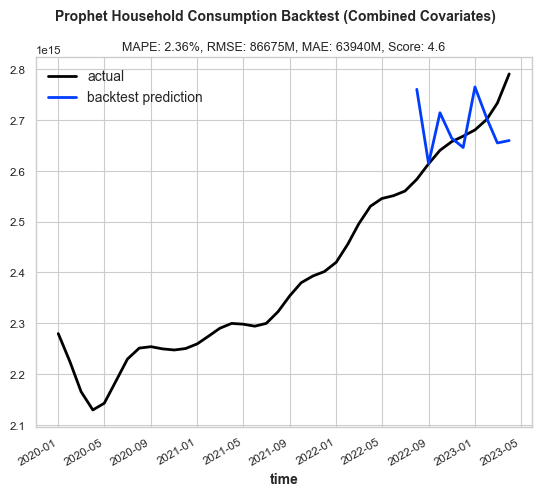

In [22]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=prophet_combined,  
                train=household_consumption,
                cov=combined,
                suptitle='Prophet Household Consumption Backtest (Combined Covariates)',
                start_val=0.8)

##### Save Prophet Model used to Nowcast on Full Dataset with Combine Covariates

In [23]:
model_pkl(prophet_combined, 'household_consumption_prophet_combined')

household_consumption_prophet_combined saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


## Bayesian Ridge Regression

##### Evaluate Bayesian Ridge with Google Trends Covariate

In [24]:
# Instantiate Bayesian Ridge model for training with Google Trends data as future covariates
bayesian_google_trends = RegressionModel(
                            lags=val_household_consumption_len,
                            lags_future_covariates=(val_household_consumption_len*2,val_household_consumption_len),
                            model=BayesianRidge(),
                            output_chunk_length=val_household_consumption_len,
)

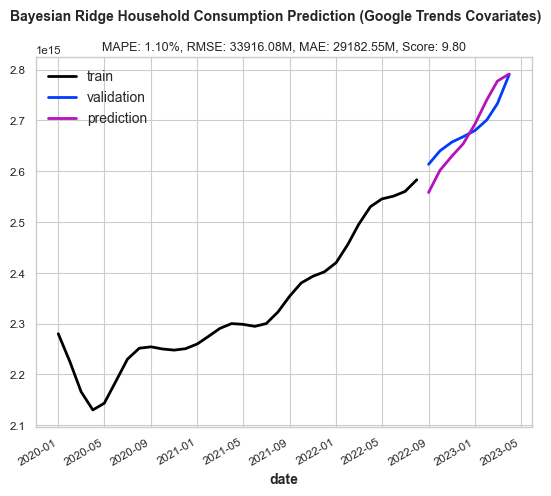

In [25]:
# Fit the Bayesian Ridge model with train_household_consumption and google_trends
plot_pred_ml(model = bayesian_google_trends, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = google_trends, 
                 suptitle = 'Bayesian Ridge Household Consumption Prediction (Google Trends Covariates)')

##### Historical Forecast (backtest) Bayesian Ridge Model with Google Trends Covariates on Full Dataset

In [26]:
# Instantiate a production Bayesian Ridge model with Google Trends Covariates
bayesian_google_trends_prod = RegressionModel(
                           lags=google_trends_diff_len,
                            lags_future_covariates=(google_trends_diff_len*2,google_trends_diff_len),
                            model=BayesianRidge(),
                           output_chunk_length=google_trends_diff_len,)

  0%|          | 0/9 [00:00<?, ?it/s]

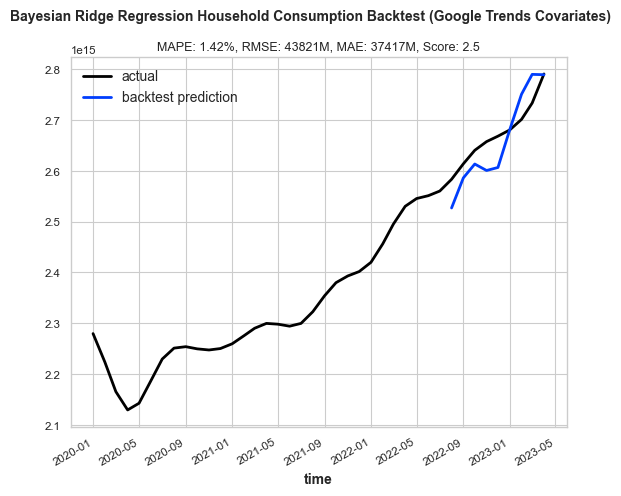

In [27]:
# Backtest the model with household_consumption data and google_trends covariate
plot_ml_backtest(model=bayesian_google_trends_prod, 
                train=household_consumption, 
                cov=google_trends,
                suptitle='Bayesian Ridge Regression Household Consumption Backtest (Google Trends Covariates)',
                start_val=0.8)

##### Save Bayesian Ridge Model Used to Nowcast on Full Dataset with Google Trends Covariates

In [28]:
model_pkl(bayesian_google_trends_prod, 'household_consumption_bayesian_google_trends')

household_consumption_bayesian_google_trends saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate Bayesian Ridge Regression with Electronic Transaction Nominal Covariate

In [29]:
# Instantiate Bayesian Ridge model for training with Electronic Payment Transaction data as future covariates
bayesian_electronic_transaction_nom = RegressionModel(
                                    lags=val_household_consumption_len,
                                    lags_future_covariates=(val_household_consumption_len*2,val_household_consumption_len),
                                    model=BayesianRidge(),
                                    output_chunk_length=val_household_consumption_len)

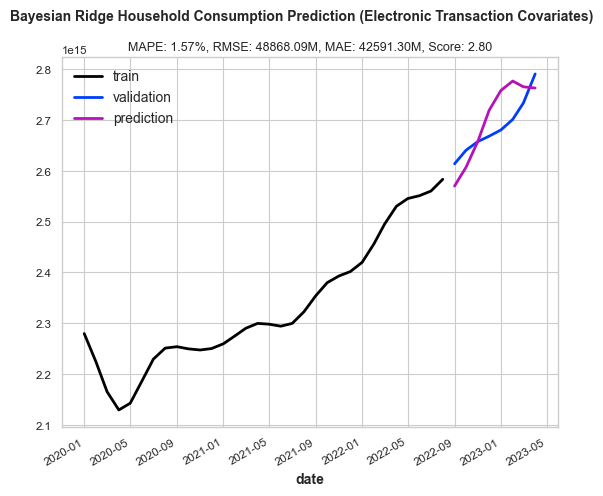

In [30]:
# Fit the bayesian ridge model with train_household_consumption and electronic_transaction_nom
plot_pred_ml(model = bayesian_electronic_transaction_nom, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = electronic_transaction_nom, 
                 suptitle = 'Bayesian Ridge Household Consumption Prediction (Electronic Transaction Covariates)')

##### Historical Forecast (backtest) Bayesian Ridge Model with Electronic Transaction Nominal Covariates on Full Dataset

In [31]:
# Instantiate a production Bayesian Ridge model with Electronic Transaction Covariates
bayesian_electronic_transaction_nom_prod = RegressionModel(
                                   lags=electronic_transaction_nom_diff_len,
                                 lags_future_covariates=(electronic_transaction_nom_diff_len*2, electronic_transaction_nom_diff_len),
                                  model=BayesianRidge(),
                                    output_chunk_length=electronic_transaction_nom_diff_len)

  0%|          | 0/9 [00:00<?, ?it/s]

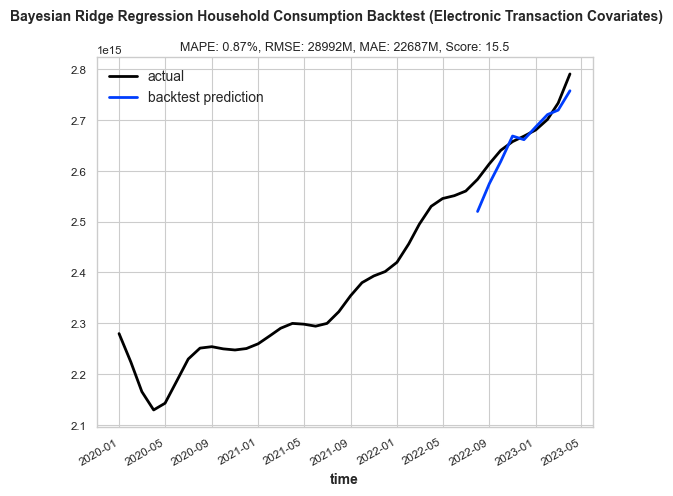

In [32]:
# Backtest the model with household_consumption data and electronic_transaction_nom covariate
plot_ml_backtest(model = bayesian_electronic_transaction_nom_prod, 
                 train=household_consumption,
                 cov=electronic_transaction_nom,
                 suptitle='Bayesian Ridge Regression Household Consumption Backtest (Electronic Transaction Covariates)',
                 start_val=0.8)

##### Save Bayesian Ridge Model used to Nowcast on Full Dataset with Electronic Transaction Nominal Covariates

In [33]:
model_pkl(bayesian_electronic_transaction_nom_prod, 'household_consumption_bayesian_electronic_transaction_nom')

household_consumption_bayesian_electronic_transaction_nom saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate Bayesian Ridge Regression with Combined Covariate

In [34]:
# Initialize Prophet model for training with combined data as future covariates
bayesian_combined = RegressionModel(
                    lags=val_household_consumption_len,
                    lags_future_covariates=(val_household_consumption_len*2, val_household_consumption_len),
                    model=HuberRegressor(),
                    output_chunk_length=val_household_consumption_len)

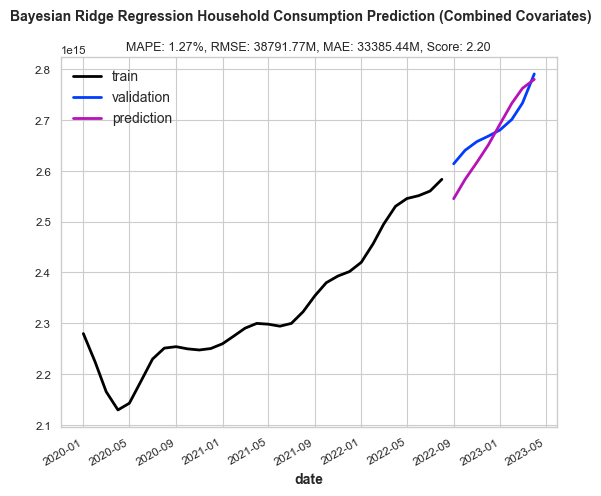

In [35]:
# Fit the model with train_household_consumption and combined covariates
plot_pred_ml(model = bayesian_combined, 
                 len = val_household_consumption_len, 
                 train = train_household_consumption, 
                 val = val_household_consumption, 
                 cov = combined, 
                 suptitle='Bayesian Ridge Regression Household Consumption Prediction (Combined Covariates)')

##### Historical Forecast (backtest) Bayesian Ridge Model with Combined Covariates on Full Dataset

In [36]:
# Instantiate production Huber Regression Model with combined covariates
bayesian_combined_prod = RegressionModel(
                        lags=combined_diff_len,
                       lags_future_covariates=(combined_diff_len*2, combined_diff_len),
                     model=BayesianRidge(),
                       output_chunk_length=combined_diff_len)


  0%|          | 0/9 [00:00<?, ?it/s]

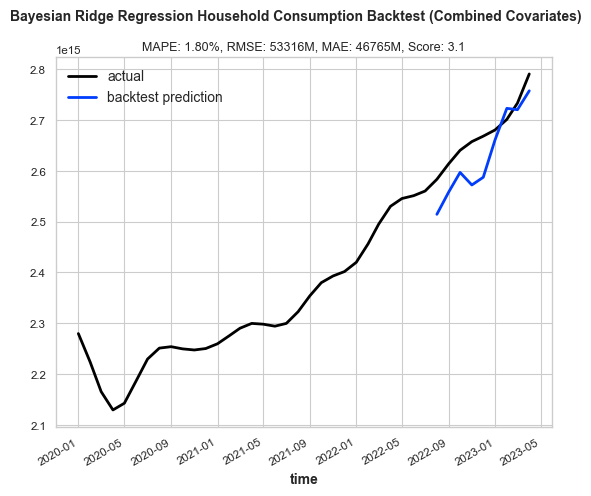

In [37]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=bayesian_combined_prod, 
                 train=household_consumption,
                 cov=combined,
                 suptitle='Bayesian Ridge Regression Household Consumption Backtest (Combined Covariates)',
                 start_val=0.8)

##### Save Bayesian Ridge Model used to Nowcast on Full Dataset with Combined Covariates

In [38]:
model_pkl(bayesian_combined_prod, 'household_consumption_bayesian_combined')

household_consumption_bayesian_combined saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


## LSTM

##### Evaluate LSTM with combined Google Trends covariates

In [39]:
# Initialize LSTM model for training with electronic_transaction_nom covariates
lstm_google_trends = RNNModel(
                        model="LSTM",                                      # type of recurrent network (RNN, LSTM, GRU)
                        hidden_dim=30,                                     # dimension of the hidden state vector
                        dropout=0.2,                                       # dropout parameter
                        batch_size=16,                                     # batch size
                        n_epochs=300,                                      # number of epochs
                        optimizer_kwargs={"lr": 1e-3},                     # arguments passed to the optimizer
                        model_name="google_trends_RNN",                    # name used for checkpoints
                        log_tensorboard=True,                              # enable tensorboard logging
                        random_state=42,                                   # random state
                        training_length=val_household_consumption_len*2,   # specify the training length
                        input_chunk_length=val_household_consumption_len,  # specify the input chunk length
                        force_reset=True,                                  # force reset
                        save_checkpoints=True)                             # save checkpoints

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

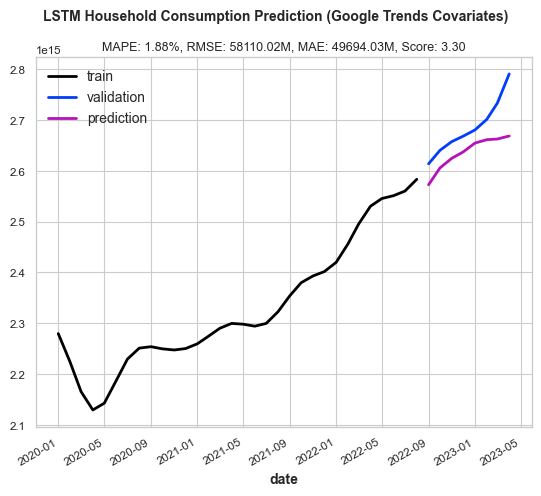

In [40]:
# Fit the LSTM model with train_household_consumption and combined
plot_pred_ml(model=lstm_google_trends, 
                 len=val_household_consumption_len, 
                 train=train_household_consumption, 
                 val=val_household_consumption, 
                 cov=google_trends, 
                 suptitle='LSTM Household Consumption Prediction (Google Trends Covariates)')

##### Historical Forecast (backtest) LSTM Model with Google Trends Covariates on Full Dataset

In [41]:
# Instantiate production LSTM model for training with google_trends data as future covariates
lstm_google_trends_prod = RNNModel(
                        model="LSTM",
                        hidden_dim=30,
                        dropout=0.2,
                        batch_size=16,
                        n_epochs=300,
                        optimizer_kwargs={"lr": 1e-3},
                        model_name="google_trends_RNN_prod",
                        log_tensorboard=True,
                        random_state=42,
                        training_length=google_trends_diff_len*2,
                        input_chunk_length=google_trends_diff_len,
                        force_reset=True,
                        save_checkpoints=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

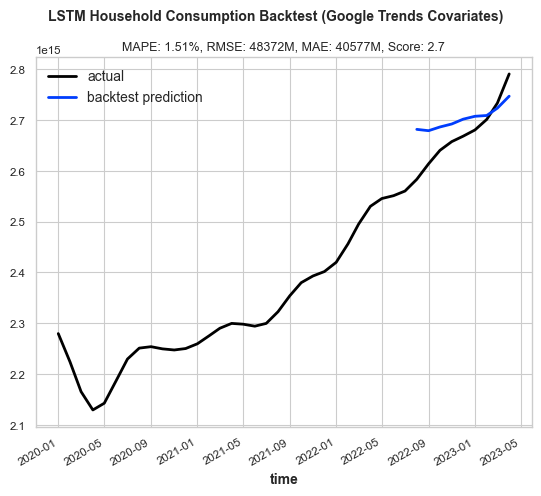

In [42]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=lstm_google_trends_prod, 
                 train=household_consumption,
                 cov=google_trends,
                 suptitle='LSTM Household Consumption Backtest (Google Trends Covariates)',
                 start_val=0.8)

##### Save LSTM Model used to Nowcast on Full Dataset with Google Trends Covariates

In [43]:
model_pkl(lstm_google_trends_prod, 'household_consumption_lstm_google_trends')

household_consumption_lstm_google_trends saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate LSTM with Electronic Transaction Nominal Covariate

In [44]:
# Initialize LSTM model for training with electronic_transaction_nom covariates
lstm_electronic_transaction_nom = RNNModel(
                        model="LSTM",
                        hidden_dim=30,
                        dropout=0.2,
                        batch_size=16,
                        n_epochs=300,
                        optimizer_kwargs={"lr": 1e-3},
                        model_name="electronic_transac_nom_RNN",
                        log_tensorboard=True,
                        random_state=42,
                        training_length=val_household_consumption_len*2,
                        input_chunk_length=val_household_consumption_len,
                        force_reset=True,
                        save_checkpoints=True)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

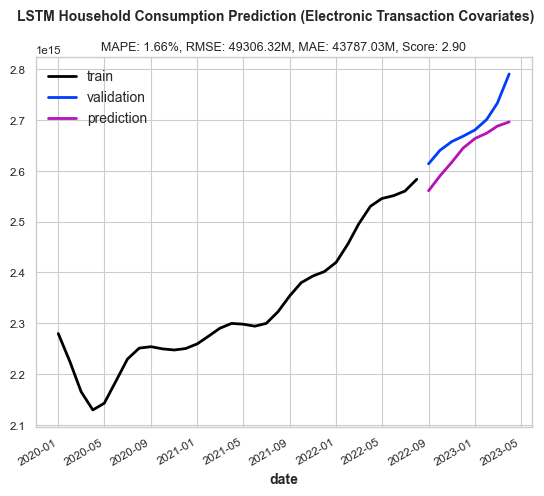

In [45]:
# Fit the LSTM model with train_household_consumption and electronic_transaction_nom
plot_pred_ml(model=lstm_electronic_transaction_nom, 
                 len=val_household_consumption_len, 
                 train=train_household_consumption, 
                 val=val_household_consumption, 
                 cov=electronic_transaction_nom, 
                 suptitle='LSTM Household Consumption Prediction (Electronic Transaction Covariates)')

##### Historical Forecast (backtest) LSTM Model with Electronic Transaction Nominal Covariates on Full Dataset

In [46]:
# Instantiate production LSTM model for training with electronic_transaction_nom covariates
lstm_electronic_transaction_nom_prod = RNNModel(
                            model="LSTM",
                            hidden_dim=30,
                            dropout=0.2,
                            batch_size=16,
                            n_epochs=300,
                            optimizer_kwargs={"lr": 1e-3},
                            model_name="electronic_transac_nom_RNN_prod",
                            log_tensorboard=True,
                            random_state=42,
                            training_length=electronic_transaction_nom_diff_len*2,
                            input_chunk_length=electronic_transaction_nom_diff_len,
                            force_reset=True,
                            save_checkpoints=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

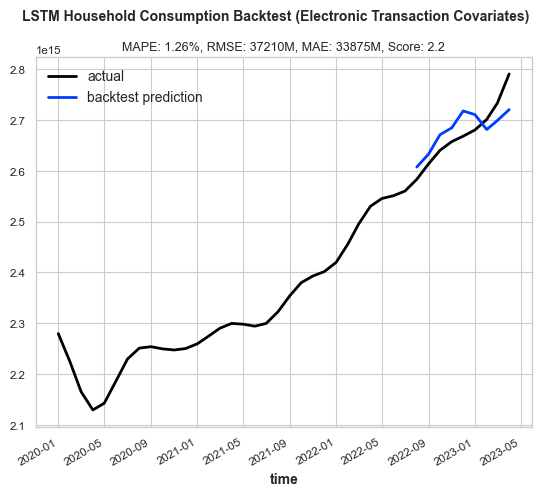

In [47]:
# Backtest the model with household_consumption data
plot_ml_backtest(model=lstm_electronic_transaction_nom_prod, 
                 train=household_consumption,
                 cov=electronic_transaction_nom,
                 suptitle='LSTM Household Consumption Backtest (Electronic Transaction Covariates)',
                 start_val=0.8)

##### Save LSTM Model used to Nowcast on Full Dataset with Electronic Transaction Nominal Covariates

In [48]:
model_pkl(lstm_electronic_transaction_nom_prod, 'household_consumption_lstm_electronic_transaction_nom')

household_consumption_lstm_electronic_transaction_nom saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\


##### Evaluate LSTM with Combined Covariate

In [49]:
# Initialize LSTM model for training with combined covariate
lstm_combined = RNNModel(
                    model="LSTM",
                    hidden_dim=20,
                    dropout=0.2,
                    batch_size=16,
                    n_epochs=300,
                    optimizer_kwargs={"lr": 1e-3},
                    model_name="combined_RNN",
                    log_tensorboard=True,
                    random_state=42,
                    training_length=val_household_consumption_len*2,
                    input_chunk_length=val_household_consumption_len,
                    force_reset=True,
                    save_checkpoints=True,)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

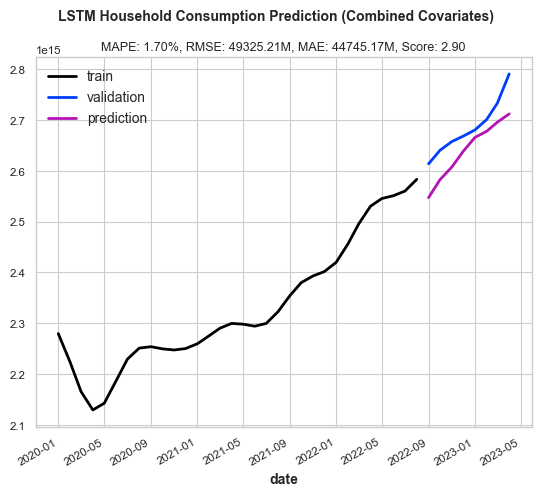

In [50]:
# Fit the LSTM model with train_household_consumption and combined
plot_pred_ml(model=lstm_combined, 
                 len=val_household_consumption_len, 
                 train=train_household_consumption, 
                 val=val_household_consumption, 
                 cov=combined, 
                 suptitle='LSTM Household Consumption Prediction (Combined Covariates)')

##### Historical Forecast (backtest) LSTM Model with Combined Covariates on Full Dataset

In [51]:
# Instantiate production LSTM model for training with combined covariates
lstm_combined_prod = RNNModel(
                        model="LSTM",
                        hidden_dim=20,
                        dropout=0.2,
                        batch_size=16,
                        n_epochs=300,
                        optimizer_kwargs={"lr": 1e-3},
                        model_name="combined_RNN_prod",
                        log_tensorboard=True,
                        random_state=42,
                        training_length=combined_diff_len*2,
                        input_chunk_length=combined_diff_len,
                        force_reset=True,
                        save_checkpoints=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

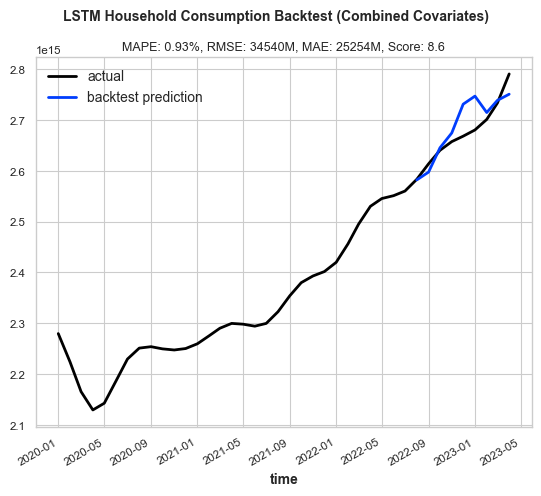

In [52]:
# Backtest the model with combined covariate
plot_ml_backtest(model=lstm_combined_prod,  
                 train=household_consumption,
                 cov=combined,
                 suptitle='LSTM Household Consumption Backtest (Combined Covariates)',
                 start_val=0.8)

##### Save LSTM Model used to Nowcast on Full Dataset with Combined Covariates

In [53]:
model_pkl(lstm_combined_prod, 'household_consumption_lstm_combined')

household_consumption_lstm_combined saved to C:\Users\ASUS\OneDrive - Universiti Malaya\Sem 7\FYP\Model pkl\\
